# Perkenalan

**Nama**    : **Ahmad Qais Alfiansyah**  
**Batch**   : **RMT-027**  
**Project** : **Graded Challenge 6**  

<hr>

## Latar Belakang Masalah

Saya sedang diminta untuk melakukan prediksi gaji oleh sebuah badan pemerintahan di Texas. Prediksi gaji di sini termasuk tanpa terkecuali ke instansi semua badan pemerintahan Texas. Saya dibekali sebuah dataset dari link berikut:  
https://data.world/texastribune/texas-government-salaries-explorer  

Dataset pada link tersebut adalah dataset dari waktu ke waktu sekitar tahun 90an. Tetapi saya diminta untuk hanya menggunakan data dari tahun 2023 saja untuk memprediksi prekrutan karyawan baru di lingkungan ppada tahun 2024 ini.  

Adapun saya memprediksi dataset dengan beberapa model ensemble learning seperti: KNN, Radnom Forest, Gradient Booster guna bisa mengetahui mana yang paling bagus scorenya dari hasil evaluasi.  

Akhirnya saya menemukan model yang tepat yang tertera pada bagian akhir notebook ini.

## Objective:
Prediksi Gaji Karyawan Baru

## Conceptual Problems:

<blockquote>
Jelaskan latar belakang adanya bagging dan cara kerja bagging !
</blockquote><br>
Sepengetahuan saya tentang Bagging atau Bootstrap AGGregating:  
- Bagging adalah teknik ML untuk meningkatkan akurasi dari sebuah model ML dengan kompleksitas yang tinggi. Bagging bisa mengurangi overfitting karena pada dasarnya berbicara dimensi ataupun kompleksitas pemodelan yang tinggi, Machine hasil score pemodelan train akan lebih tinggi bahkan jauh perbedaannya dengan hasil test atau predict unseen data.  
- Cara kerja Bagging adalah pertama sampel bootstrap dibuat dengan menggunakan state number kemudian dicoba train ke beberapa model. Setelah itu di evaluasi melalui rata-rata kalau regresi. Sedangkan untuk klasifikasi pakai vote. Proses ini disebut Aggregating.   
- Pada kasus regresi seperti di notebook ini, teknik bagging tidak umum digunakan.  

<br><blockquote>
Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih!
</blockquote><br>
Saya menggunakan Gradient Boosting Regressor dan juga Random Forest dalam hal ini, karena menurut saya ini adalah algoritma yang cukup efektif dalam menghasilkan model yang akurat. Perbedaan mungkin terlihat dari cara membuat modelnya di belakang layar. Random Forest dibuat caranya dengan seperti membangun pohon keputusan yang secara independen digabungkan hasil prediksinya. Sementara dalam  Gradient Regressor, error dari model sebelumnya akan dijadikan pelajaran oleh model selanjutnya.  

<br><blockquote>
Jelaskan apa yang dimaksud dengan Cross Validation !
</blockquote><br>
Cross-validation algoritma untuk mengevaluasi model Gradient Boosting Regressor atau Random Forest. Dalam konteks saya dalam memprediksi gaji, cross-validation untuk seperti membuat metriks atau vektor yang lebih keci; dan di latih pada poin-point itu. Sehingga tidak banyak noise yang dihasilkan.  

# Import Libraries

Berikut adalah Libraries yang saya pergunakan

In [178]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, r2_score, mean_squared_error

import joblib
import pickle
import warnings
warnings.filterwarnings('ignore') #turn off warning

Untuk memudahkan pemberian warna. Saya kumpulkan color code preferensi di sini

In [179]:
color_codes = [
    '#1d3d71ff',
    '#f26634ff',
    '#b19802ff',
    '#56a3a6ff',
    '#80a4edff',
    '#1be7ffff',
    '#df57bcff',
    '#496f5dff',
    '#88a0a8ff',
    '#00c49aff']

# Data Loading

## Load dan Filter Data .csv 

Saya akan maksimalkan tampilan baris supaya tidak ada baris tersembunyi di tengah. Khususnya pada saat menampilkan .info()

In [180]:
pd.set_option("display.max_columns", 25)
pd.set_option("display.max_rows", 25)
df= pd.read_csv('./TTGovtSalaries_latest.csv', low_memory=False)

## Memilh tahun sesuai permintaan

Format dataset ini masih sangat raw, sehingga harus dilakukan beberapa langkah sebelum akhirnya bisa memfilter tahun yang dinginkan

In [181]:
df[['month_hired','date_hired', 'year_hired']] = df['HIREDT'].str.split('/', expand=True)
df= df.drop('HIREDT', axis=1)

for col in ['month_hired', 'date_hired']:
    df[col] = df[col].str.lstrip('0')

# Loop untuk menambahkan 2 digit angka '19' atau '20' pada tahun
for idx, year in enumerate(df['year_hired']):
    if int(year) > 24:
        df.at[idx, 'year_hired'] = '19' + year
    else:
        df.at[idx, 'year_hired'] = '20' + year

Memilih tahun 2023 saja ke dalam df

In [182]:
df=df[df['year_hired']== '2023']
df

,AGY,NAME,LASTNAME,FIRSTNAME,MI,JOBCLASS,JC TITLE,RACE,SEX,EMPTYPE,RATE,HRSWKD,MONTHLY,ANNUAL,STATENUM,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,month_hired,date_hired,year_hired
6,101,SENATE ...,GONZALEZ,CYNTHIA,D,7101,LEG. OFFICIAL/ADMINISTRATOR ...,HISPANIC,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,20.0,2375.00,28500.00,1252876,True,NaN,NaN,NaN,True,9,1,2023
8,101,SENATE ...,HERNANDEZ,JOHN,Z,7103,LEG. SERVICE/MAINTENANCE ...,HISPANIC,MALE,UTP - UNCLASSIFIED TEMPORARY PART-TIME,20.0,1.0,86.66,1039.92,1573852,True,NaN,NaN,NaN,True,7,5,2023
11,101,SENATE ...,MALDANADO,ALEXANDER,P,7102,LEGISLATIVE ADMIN. SUPPORT ...,HISPANIC,MALE,UTP - UNCLASSIFIED TEMPORARY PART-TIME,14.0,20.0,1213.33,14559.96,1631392,True,NaN,NaN,20559.96,NaN,4,11,2023
12,102,HOUSE OF REPRESENTATIVES ...,MALDANADO,ALEXANDER,P,7110,ELECTED OFFICIALS STAFF ...,HISPANIC,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,20.0,500.00,6000.00,1631392,True,NaN,NaN,NaN,True,8,14,2023
14,104,LEGISLATIVE BUDGET BOARD ...,MCGHEE,ANDREA,P,P070,ANALYST ...,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,30.0,3000.00,36000.00,1055926,True,NaN,NaN,NaN,True,9,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146404,930,TREASURY SAFEKEEPING TRUST COMPANY ...,JENTSCH,KEVIN,F,1022,ACCOUNTANT VI ...,WHITE,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,7500.00,90000.00,1577922,NaN,NaN,NaN,NaN,NaN,1,17,2023
146410,930,TREASURY SAFEKEEPING TRUST COMPANY ...,LEE,HOI WAI,,0215,DATA ADMIN V ...,ASIAN,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,9167.00,110004.00,1669507,NaN,NaN,NaN,NaN,NaN,9,15,2023
146436,930,TREASURY SAFEKEEPING TRUST COMPANY ...,SURESH,SRI VAISHNAVI G,,0257,SYSTEM ANALYST VI ...,ASIAN,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,10272.15,123265.80,1643065,NaN,NaN,NaN,NaN,NaN,6,1,2023
146443,930,TREASURY SAFEKEEPING TRUST COMPANY ...,URBAN,DIANA,E,1562,PROJECT MANAGER V ...,WHITE,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,10500.00,126000.00,423121,NaN,NaN,NaN,NaN,NaN,2,1,2023


Dataset sudah terfilter. Sekarang saya akan cek informasi datasetnya

## Informasi Data

Saya akan menampilkan 5 baris pertama dan terakhir

In [183]:
pd.concat([df.head(5), df.tail(5)])

,AGY,NAME,LASTNAME,FIRSTNAME,MI,JOBCLASS,JC TITLE,RACE,SEX,EMPTYPE,RATE,HRSWKD,MONTHLY,ANNUAL,STATENUM,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,month_hired,date_hired,year_hired
6,101,SENATE ...,GONZALEZ,CYNTHIA,D,7101,LEG. OFFICIAL/ADMINISTRATOR ...,HISPANIC,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,20.0,2375.00,28500.00,1252876,True,NaN,NaN,NaN,True,9,1,2023
8,101,SENATE ...,HERNANDEZ,JOHN,Z,7103,LEG. SERVICE/MAINTENANCE ...,HISPANIC,MALE,UTP - UNCLASSIFIED TEMPORARY PART-TIME,20.0,1.0,86.66,1039.92,1573852,True,NaN,NaN,NaN,True,7,5,2023
11,101,SENATE ...,MALDANADO,ALEXANDER,P,7102,LEGISLATIVE ADMIN. SUPPORT ...,HISPANIC,MALE,UTP - UNCLASSIFIED TEMPORARY PART-TIME,14.0,20.0,1213.33,14559.96,1631392,True,NaN,NaN,20559.96,NaN,4,11,2023
12,102,HOUSE OF REPRESENTATIVES ...,MALDANADO,ALEXANDER,P,7110,ELECTED OFFICIALS STAFF ...,HISPANIC,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,20.0,500.00,6000.00,1631392,True,NaN,NaN,NaN,True,8,14,2023
14,104,LEGISLATIVE BUDGET BOARD ...,MCGHEE,ANDREA,P,P070,ANALYST ...,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,30.0,3000.00,36000.00,1055926,True,NaN,NaN,NaN,True,9,1,2023
146404,930,TREASURY SAFEKEEPING TRUST COMPANY ...,JENTSCH,KEVIN,F,1022,ACCOUNTANT VI ...,WHITE,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,7500.00,90000.00,1577922,NaN,NaN,NaN,NaN,NaN,1,17,2023
146410,930,TREASURY SAFEKEEPING TRUST COMPANY ...,LEE,HOI WAI,,0215,DATA ADMIN V ...,ASIAN,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,9167.00,110004.00,1669507,NaN,NaN,NaN,NaN,NaN,9,15,2023
146436,930,TREASURY SAFEKEEPING TRUST COMPANY ...,SURESH,SRI VAISHNAVI G,,0257,SYSTEM ANALYST VI ...,ASIAN,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,10272.15,123265.80,1643065,NaN,NaN,NaN,NaN,NaN,6,1,2023
146443,930,TREASURY SAFEKEEPING TRUST COMPANY ...,URBAN,DIANA,E,1562,PROJECT MANAGER V ...,WHITE,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,10500.00,126000.00,423121,NaN,NaN,NaN,NaN,NaN,2,1,2023
146444,930,TREASURY SAFEKEEPING TRUST COMPANY ...,VARA-OLVERA,ALEJANDRA,,1573,PROGRAM SPECIALIST IV ...,HISPANIC,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,0.0,40.0,6456.45,77477.40,52005,NaN,NaN,NaN,NaN,NaN,6,1,2023


Terlihat banyak sekali NaN di kolom-kolom terakhir

Selanjutnya di sini saya mencoba menampilkan informasi Dataset dengan menggunakan keyword .info()

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGY                      23857 non-null  int64  
 1   NAME                     23857 non-null  object 
 2   LASTNAME                 23857 non-null  object 
 3   FIRSTNAME                23857 non-null  object 
 4   MI                       23857 non-null  object 
 5   JOBCLASS                 23857 non-null  object 
 6   JC TITLE                 23857 non-null  object 
 7   RACE                     23857 non-null  object 
 8   SEX                      23857 non-null  object 
 9   EMPTYPE                  23857 non-null  object 
 10  RATE                     23857 non-null  float64
 11  HRSWKD                   23857 non-null  float64
 12  MONTHLY                  23857 non-null  float64
 13  ANNUAL                   23857 non-null  float64
 14  STATENUM                 2

Terlihat jelas dari sini di setidaknya kolom ke 17 - 20 data terisi tersisa kurang dari 10. Saya akan melihat terlebih dahulu komposisi tipe datanya 

In [185]:
print(f"Terlihat dataset memiliki jumlah kolom sebanyak {df.columns.nunique()} kolom diantaranya:")
print(f"Tipe Float berjumlah {(df.dtypes == 'float').sum()} kolom")
print(f"Tipe Interger berjumlah {(df.dtypes == 'int').sum()} kolom")
print(f"Tipe Object atau String berjumlah {(df.dtypes == 'object').sum()} kolom")

Terlihat dataset memiliki jumlah kolom sebanyak 23 kolom diantaranya:
Tipe Float berjumlah 5 kolom
Tipe Interger berjumlah 2 kolom
Tipe Object atau String berjumlah 16 kolom


Ok, kolom-kolom object sangatlah banyak. Saya akan coba membersihkannya

# Data Cleaning

## Cek Missing Value

Pada tahap ini saya akan cek Missing Value.

In [186]:
missing_value = df.isnull().sum()
missing_value[missing_value > 0]

duplicated                 23843
multiple_full_time_jobs    23850
combined_multiple_jobs     23857
summed_annual_salary       23855
hide_from_search           23852
dtype: int64

5 kolom ini akan saya drop karena jika saya hapus barisnya. Maka habislah dataset saya. Terlebih kolom ini termasuk inrelevant dengan objective saya.  

In [187]:
df= df.dropna(axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGY          23857 non-null  int64  
 1   NAME         23857 non-null  object 
 2   LASTNAME     23857 non-null  object 
 3   FIRSTNAME    23857 non-null  object 
 4   MI           23857 non-null  object 
 5   JOBCLASS     23857 non-null  object 
 6   JC TITLE     23857 non-null  object 
 7   RACE         23857 non-null  object 
 8   SEX          23857 non-null  object 
 9   EMPTYPE      23857 non-null  object 
 10  RATE         23857 non-null  float64
 11  HRSWKD       23857 non-null  float64
 12  MONTHLY      23857 non-null  float64
 13  ANNUAL       23857 non-null  float64
 14  STATENUM     23857 non-null  int64  
 15  month_hired  23857 non-null  object 
 16  date_hired   23857 non-null  object 
 17  year_hired   23857 non-null  object 
dtypes: float64(4), int64(2), object(12)
memory usage: 

Di atas adalah iniformasi dataset yang tersisa setelah drop 5 kolom.

## Penyesuaian Kolom dan Value

### Hapus White Space

Say mencurigai terdapat whitespace saat saya coba-coba melakukan eksplorasi. Saya akan menghapus semua kolom yang terdapat whitespace.

In [188]:
for col in df.columns:
    df[col] = df[col].astype(str)
    df[col] = df[col].str.strip()

Whitespace seharusnya sudah terhapus.

### Hapus kepanjangan EMPTYPE

Kolom EMPTYPE adakah Tipe Employe. Jadi ini adalah kelompok pekerha berdasarkan status pekerjaannya

In [189]:
df["EMPTYPE"].unique()

array(['URP - UNCLASSIFIED REGULAR PART-TIME',
       'UTP - UNCLASSIFIED TEMPORARY PART-TIME',
       'CRF - CLASSIFIED REGULAR FULL-TIME',
       'UTF - UNCLASSIFIED TEMPORARY FULL-TIME',
       'URF - UNCLASSIFIED REGULAR FULL-TIME',
       'CRP - CLASSIFIED REGULAR PART-TIME',
       'ERF - EXEMPT REGULAR FULL-TIME',
       'CTP - CLASSIFIED TEMPORARY PART-TIME',
       'CTF - CLASSIFIED TEMPORARY FULL-TIME'], dtype=object)

Terlihat nilai dari kolom ini sepertinya terlalu panjang. Saya akan bagi menjadi beberapa kolom, guna memudahkan Analisa

In [190]:
df["status"] = df["EMPTYPE"].str.split(" ").str[-1]
df["contract"] = df["EMPTYPE"].str.split(" ").str[-2]
df["classification"] = df["EMPTYPE"].str.split(" ").str[-3]
df["employee_type"] = df["EMPTYPE"].str.split(" ").str[0]

df= df.drop('EMPTYPE', axis=1)
df

,AGY,NAME,LASTNAME,FIRSTNAME,MI,JOBCLASS,JC TITLE,RACE,SEX,RATE,HRSWKD,MONTHLY,ANNUAL,STATENUM,month_hired,date_hired,year_hired,status,contract,classification,employee_type
6,101,SENATE,GONZALEZ,CYNTHIA,D,7101,LEG. OFFICIAL/ADMINISTRATOR,HISPANIC,FEMALE,0.0,20.0,2375.0,28500.0,1252876,9,1,2023,PART-TIME,REGULAR,UNCLASSIFIED,URP
8,101,SENATE,HERNANDEZ,JOHN,Z,7103,LEG. SERVICE/MAINTENANCE,HISPANIC,MALE,20.0,1.0,86.66,1039.92,1573852,7,5,2023,PART-TIME,TEMPORARY,UNCLASSIFIED,UTP
11,101,SENATE,MALDANADO,ALEXANDER,P,7102,LEGISLATIVE ADMIN. SUPPORT,HISPANIC,MALE,14.0,20.0,1213.33,14559.96,1631392,4,11,2023,PART-TIME,TEMPORARY,UNCLASSIFIED,UTP
12,102,HOUSE OF REPRESENTATIVES,MALDANADO,ALEXANDER,P,7110,ELECTED OFFICIALS STAFF,HISPANIC,MALE,0.0,20.0,500.0,6000.0,1631392,8,14,2023,PART-TIME,REGULAR,UNCLASSIFIED,URP
14,104,LEGISLATIVE BUDGET BOARD,MCGHEE,ANDREA,P,P070,ANALYST,WHITE,FEMALE,0.0,30.0,3000.0,36000.0,1055926,9,1,2023,PART-TIME,REGULAR,UNCLASSIFIED,URP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146404,930,TREASURY SAFEKEEPING TRUST COMPANY,JENTSCH,KEVIN,F,1022,ACCOUNTANT VI,WHITE,MALE,0.0,40.0,7500.0,90000.0,1577922,1,17,2023,FULL-TIME,REGULAR,UNCLASSIFIED,URF
146410,930,TREASURY SAFEKEEPING TRUST COMPANY,LEE,HOI WAI,,0215,DATA ADMIN V,ASIAN,MALE,0.0,40.0,9167.0,110004.0,1669507,9,15,2023,FULL-TIME,REGULAR,UNCLASSIFIED,URF
146436,930,TREASURY SAFEKEEPING TRUST COMPANY,SURESH,SRI VAISHNAVI G,,0257,SYSTEM ANALYST VI,ASIAN,FEMALE,0.0,40.0,10272.15,123265.8,1643065,6,1,2023,FULL-TIME,REGULAR,UNCLASSIFIED,URF
146443,930,TREASURY SAFEKEEPING TRUST COMPANY,URBAN,DIANA,E,1562,PROJECT MANAGER V,WHITE,FEMALE,0.0,40.0,10500.0,126000.0,423121,2,1,2023,FULL-TIME,REGULAR,UNCLASSIFIED,URF


Kolom baru sudah terbuat dari hasil slicing. 

### Menyesuaikan Kolom RACE

Di sini saya akan menyesuaikan nama value dalam kolom RACE

In [191]:

df['RACE'] = df['RACE'].replace('AM INDIAN', 'AMERICAN INDIAN')

for col in df.columns:
    if df[col].nunique() < 15:
        print(f"Kolom {col}:")
        print(df[col].unique().tolist())

Kolom RACE:
['HISPANIC', 'WHITE', 'BLACK', 'OTHER', 'ASIAN', 'AMERICAN INDIAN']
Kolom SEX:
['FEMALE', 'MALE']
Kolom month_hired:
['9', '7', '4', '8', '6', '1', '2', '5', '3']
Kolom year_hired:
['2023']
Kolom status:
['PART-TIME', 'FULL-TIME']
Kolom contract:
['REGULAR', 'TEMPORARY']
Kolom classification:
['UNCLASSIFIED', 'CLASSIFIED', 'EXEMPT']
Kolom employee_type:
['URP', 'UTP', 'CRF', 'UTF', 'URF', 'CRP', 'ERF', 'CTP', 'CTF']


### Menyesuaikan Kolom Date

Kolom Date seperti dilihat di atas formatnya masih berupa object. Saya akan slice lagi menjadi kolom berdasarkan periode waktunya.

In [192]:
df['hired_date'] = df['month_hired'] + '/' + df['date_hired'] + '/' + df['year_hired']
df['hired_date'] = pd.to_datetime(df['hired_date'], format='%m/%d/%Y')
df['hired_month_year'] = df['hired_date'].dt.to_period('M')

df= df.drop(['month_hired', 'date_hired', 'year_hired'], axis=1)


### Merubah Huruf Kapital

Nama kolom tidak baku dengan huruf kapital semua. Saya akan merubahnya menjadi huruf kecil semua

In [193]:
def format_columns(df):
    df.columns = df.columns.str.lower()
    return df

df= format_columns(df)
df.columns

Index(['agy', 'name', 'lastname', 'firstname', 'mi', 'jobclass', 'jc title',
       'race', 'sex', 'rate', 'hrswkd', 'monthly', 'annual', 'statenum',
       'status', 'contract', 'classification', 'employee_type', 'hired_date',
       'hired_month_year'],
      dtype='object')

Nama-nama kolom sudah berubah menjadi huruf kecil semua.

### Merubah Nama Kolom

Saya akan mulai merubah nama kolom supa lebih mudah dipahami

In [194]:
df.columns

Index(['agy', 'name', 'lastname', 'firstname', 'mi', 'jobclass', 'jc title',
       'race', 'sex', 'rate', 'hrswkd', 'monthly', 'annual', 'statenum',
       'status', 'contract', 'classification', 'employee_type', 'hired_date',
       'hired_month_year'],
      dtype='object')

Nama kolom sudah berhasil dirubah.

In [195]:
df = df.rename(columns={
    'agy': 'agency_code',
    'name': 'agency_name',
    'lastname': 'last_name',
    'firstname': 'first_name',
    'mi': 'middle_name_initial',
    'jobclass': 'job_class',
    'jc title': 'job_title',
    'emptype': 'employee_type',
    'hrswkd': 'hours_worked',
    'monthly': 'monthly_salary',
    'annual': 'annual_salary',
    'statenum': 'state_number',
})
df.columns

Index(['agency_code', 'agency_name', 'last_name', 'first_name',
       'middle_name_initial', 'job_class', 'job_title', 'race', 'sex', 'rate',
       'hours_worked', 'monthly_salary', 'annual_salary', 'state_number',
       'status', 'contract', 'classification', 'employee_type', 'hired_date',
       'hired_month_year'],
      dtype='object')

### Merubah Urutan Kolom

Supaya lebih mudah dalam menganalisa, saya akan mengurutkan kembali kolom berdasarkna relevansinya.

In [196]:
df = df.reindex(columns=[
    'hired_date',
    'hired_month_year',
    'agency_code',
    'agency_name',
    'last_name',
    'first_name',
    'middle_name_initial',
    'sex',
    'race',
    'state_number',
    'job_class',
    'job_title',
    'employee_type',
    'classification',
    'contract',
    'status',
    'hours_worked',
    'monthly_salary',
    'annual_salary',
])

df.head(3)

,hired_date,hired_month_year,agency_code,agency_name,last_name,first_name,middle_name_initial,sex,race,state_number,job_class,job_title,employee_type,classification,contract,status,hours_worked,monthly_salary,annual_salary
6,2023-09-01,2023-09,101,SENATE,GONZALEZ,CYNTHIA,D,FEMALE,HISPANIC,1252876,7101,LEG. OFFICIAL/ADMINISTRATOR,URP,UNCLASSIFIED,REGULAR,PART-TIME,20.0,2375.0,28500.0
8,2023-07-05,2023-07,101,SENATE,HERNANDEZ,JOHN,Z,MALE,HISPANIC,1573852,7103,LEG. SERVICE/MAINTENANCE,UTP,UNCLASSIFIED,TEMPORARY,PART-TIME,1.0,86.66,1039.92
11,2023-04-11,2023-04,101,SENATE,MALDANADO,ALEXANDER,P,MALE,HISPANIC,1631392,7102,LEGISLATIVE ADMIN. SUPPORT,UTP,UNCLASSIFIED,TEMPORARY,PART-TIME,20.0,1213.33,14559.96


### Merubah Tipe Data Kolom

Saya terbiasa membagi tipe kolom interger dan float untuk memudahkan menganalisa

In [197]:
int_cols = ['agency_code', 'state_number']
flt_cols = ['hours_worked', 'monthly_salary']

df[int_cols] = df[int_cols].apply(pd.to_numeric, errors='coerce', downcast='integer')
df[flt_cols] = df[flt_cols].apply(pd.to_numeric, errors='coerce', downcast='float')


## Cek duplicate Value

Saya akan cek apakah ada duplicate value dalam dataset ini?

In [198]:
df.duplicated().sum()

0

Ternyata tidak ada duplicate value. Saya rasa, saya bisa melanjutkan pekerjaan ke tahap EDA

# Exploratory Data Analysis (EDA)

Sampai tahp ini saya akan menyimpan kedalam file csv baru untuk kepentingan EDA di deployment.

In [199]:
df.to_csv('eda.csv', index=False)

Pertama dalama EDA, saya akan membagi tipe data numeric dan object.

In [200]:
numeric_cols = df.select_dtypes(include=['number'])
object_cols= df.select_dtypes(include=['object'])

## Deskripsi Umum Dataset

In [201]:
object_cols.describe().T

,count,unique,top,freq
agency_name,23857,106,HEALTH AND HUMAN SERVICES COMMISSION,7261
last_name,23857,10506,JOHNSON,217
first_name,23857,7469,MICHAEL,214
middle_name_initial,23857,27,,6830
sex,23857,2,FEMALE,14337
race,23857,6,WHITE,8251
job_class,23857,928,4502,2003
job_title,23857,914,CORREC OFFCR II,2003
employee_type,23857,9,CRF,21677
classification,23857,3,CLASSIFIED,22801


**Highlights**

- agency_name: Terlihat ada 106 agensi, dengan "HEALTH AND HUMAN SERVICES COMMISSION" mendominasi dengan frekuensi 7261.  
- last_name, firstname, Minitial sesuatu yang kurang relevan untuk dibahasa.  
- Gender seperti seharusnya, hanya ada 2. dengan "FEMALE" sebagai nilai modusnya.  
- Terdapat 6 ras dimana "WHITE" paling umum.
- job_class termasuk banyak tidak seperti yang saya bayangkan terdapat 928 kelas pekerjaan unik. job_title sepertinya redundat dengan job_class.  
- employee_type, classification dan contract adalah hasil ekstraksi dari kolom employee_type.  
- Annual salary sebenarnya adalh hasil pengalian dari monthly. Saya akan menghapusnya nanti.  


In [202]:
numeric_cols.describe().T

,count,mean,std,min,25%,50%,75%,max
agency_code,23857.0,5.529207e+02,135.871263,101.00,529.00,530.00,696.00,930.00
state_number,23857.0,1.341741e+06,508458.391413,158.00,1206064.00,1625879.00,1646353.00,1670651.00
hours_worked,23857.0,3.928977e+01,3.730517,1.00,40.00,40.00,40.00,40.00
monthly_salary,23857.0,4.201300e+03,1877.575955,86.66,3297.58,3824.18,4416.67,34999.99


## Analisa Data

Saya akan mulai menganalisa data. 

In [203]:
df.hours_worked.nunique()

32

## Komposisi Data

### Komposisi Data Berdasarkan Kategori

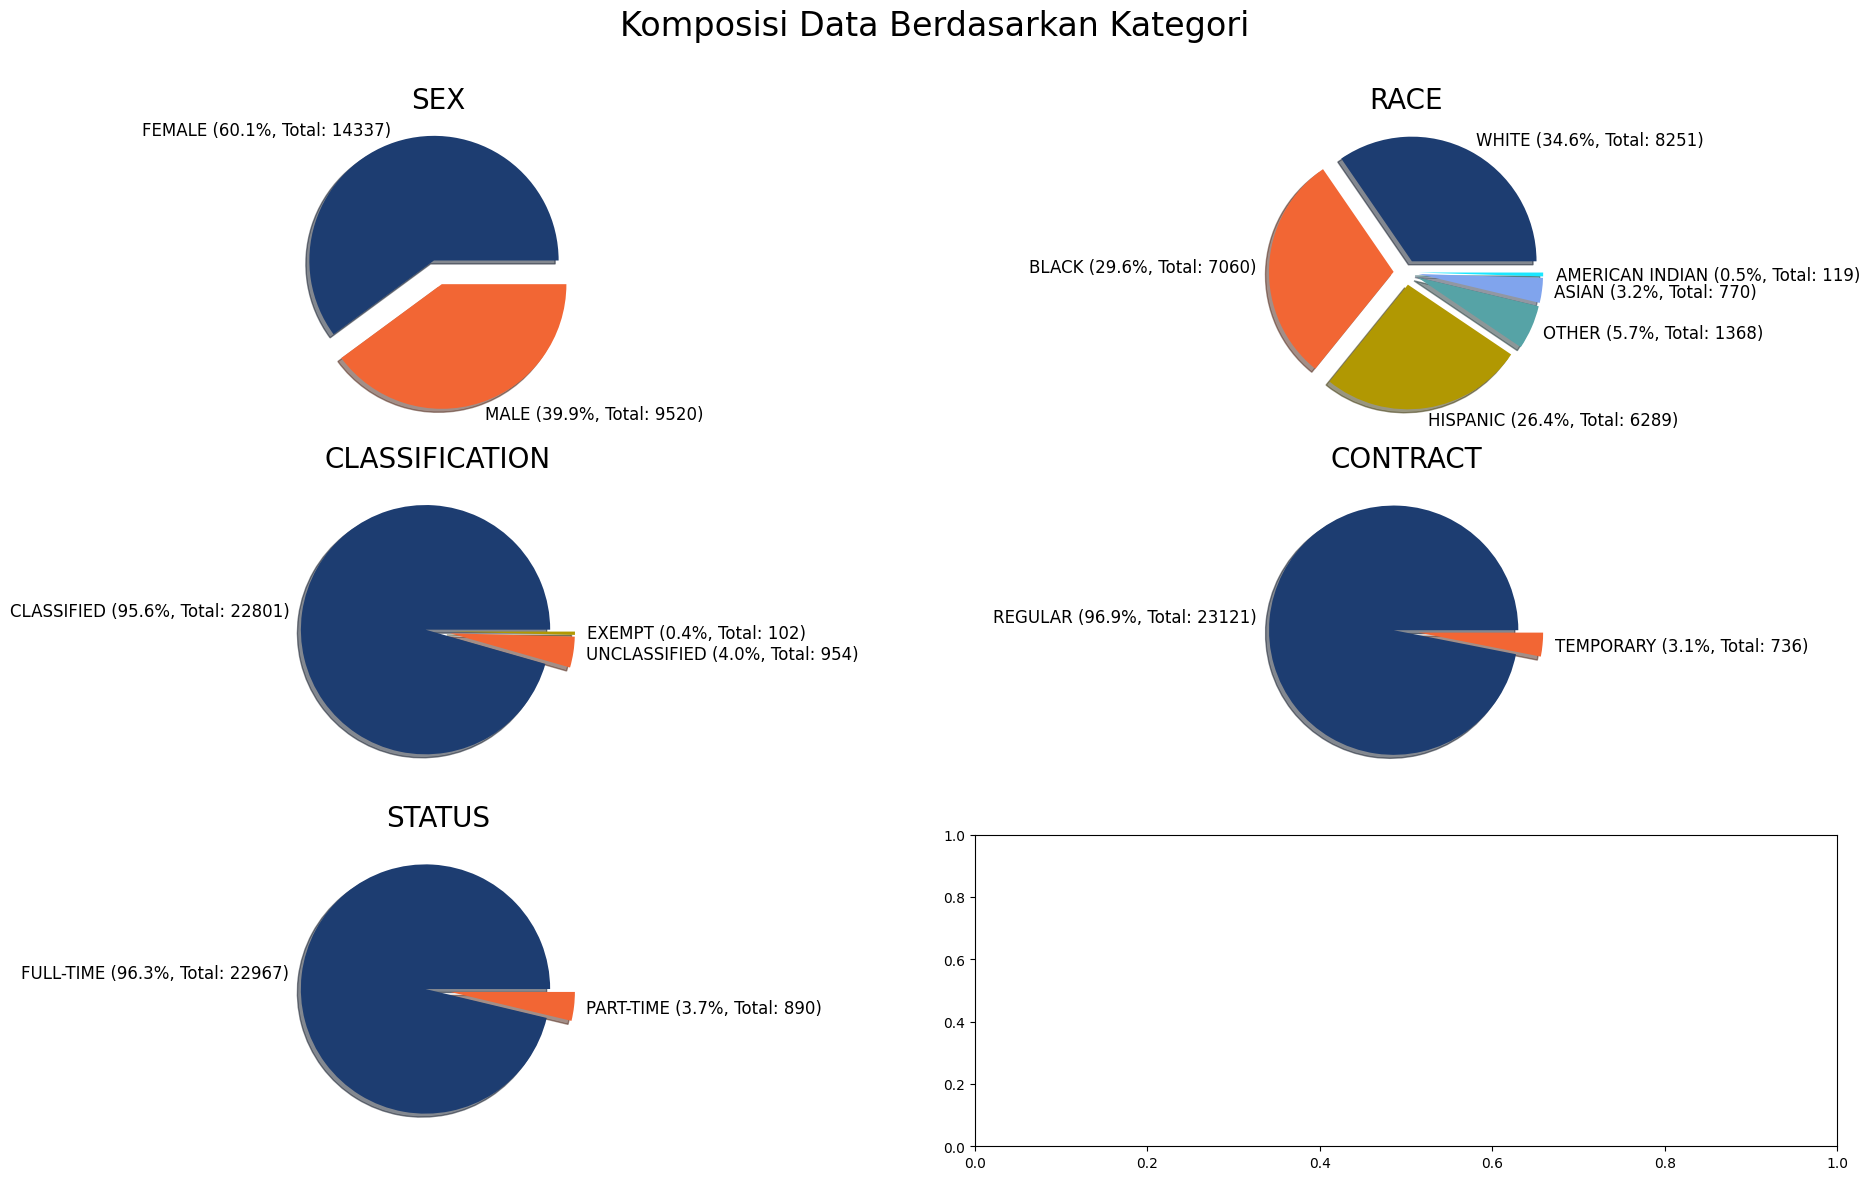

In [204]:
selected_columns = ['sex', 'race', 'classification', 'contract', 'status']

fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle('Komposisi Data Berdasarkan Kategori\n', fontsize=24, ha='center')


for i, col in enumerate(selected_columns):
    explosion = [0.1] * len(df[col].unique())
    ax = axes[i // 2, i % 2]
    count = df[col].value_counts()
    labels = [f'{index} ({(val / sum(count)) * 100:.1f}%, Total: {val})' for index, val in zip(count.index, count)]
    wedges, texts = ax.pie(count, labels=labels, shadow=True, colors=color_codes, pctdistance=0.1, explode=explosion)
    for text in texts:
        text.set_fontsize(12)  
    ax.set_title(f'{col.upper()}', fontsize=20)

plt.tight_layout()
plt.show()


## Distribusi Data

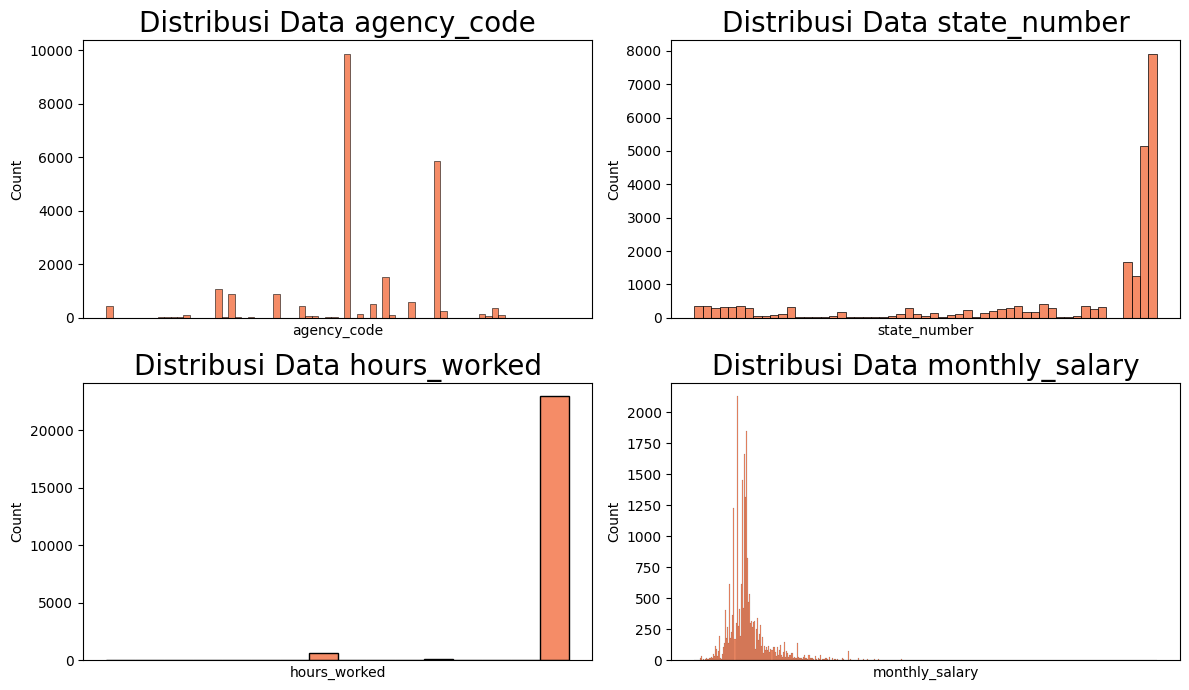

In [205]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

for i, col in enumerate(numeric_cols.columns):
    ax = axes[i // 2, i % 2] 
    sns.histplot(data=numeric_cols, x=col, color=color_codes[1], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 20)
    ax.set_xlabel(col)
    
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


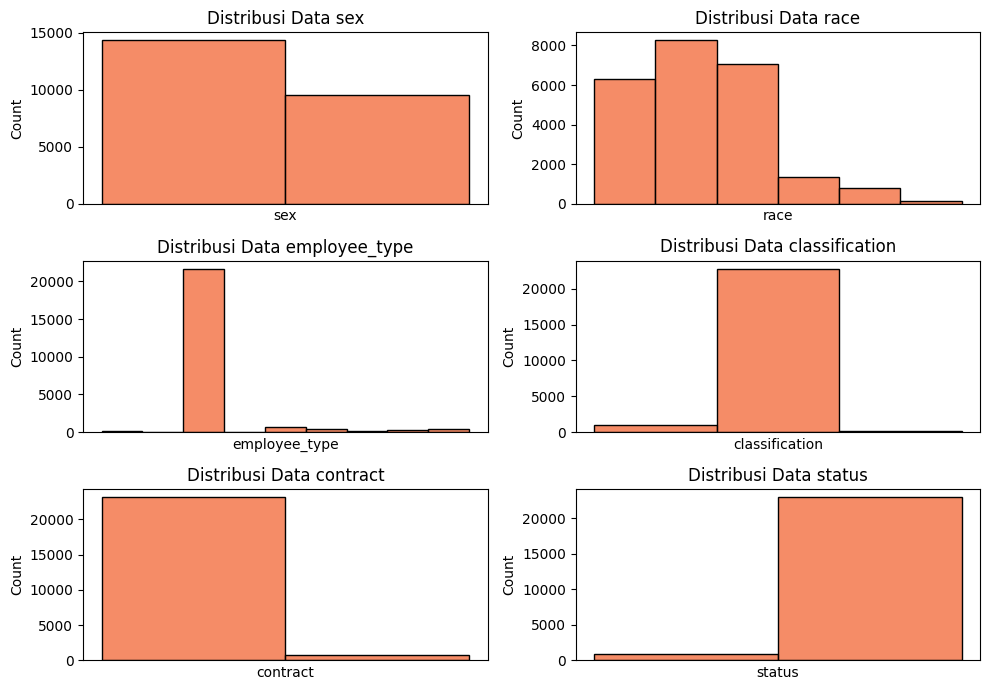

In [206]:
low_object_cols = object_cols.columns[object_cols.nunique() < 10]
low_object_cols = df[low_object_cols]
hi_object_cols = object_cols.columns[object_cols.nunique() >= 10]
hi_object_cols = df[hi_object_cols]

fig, axes = plt.subplots(3, 2, figsize=(10, 7))

for i, col in enumerate(low_object_cols.columns):
    ax = axes[i // 2, i % 2] 
    sns.histplot(data=low_object_cols, x=col, color=color_codes[1], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 12)
    ax.set_xlabel(col)
    
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


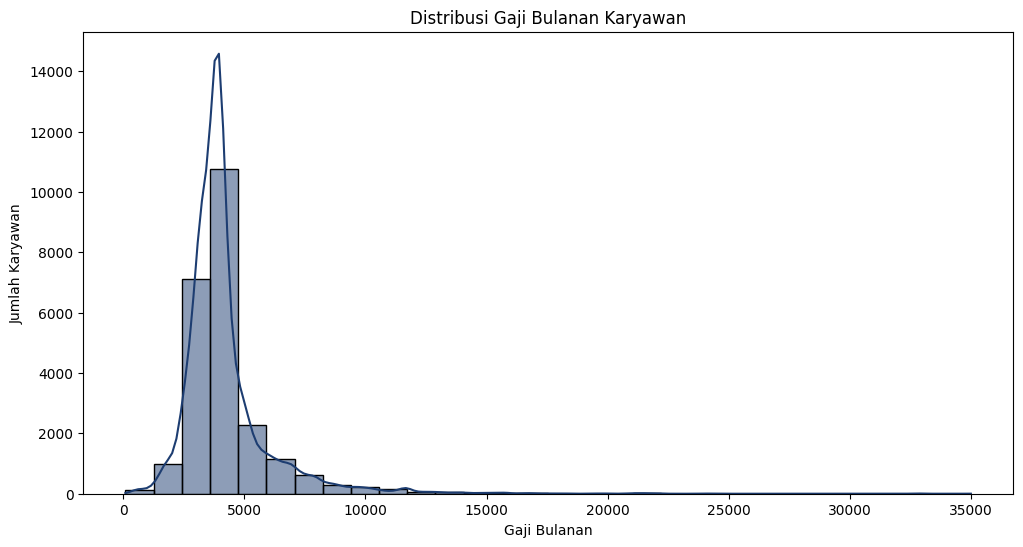

In [207]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='monthly_salary', kde=True, bins=30, color=color_codes[0])

plt.title('Distribusi Gaji Bulanan Karyawan')
plt.xlabel('Gaji Bulanan')
plt.ylabel('Jumlah Karyawan')

plt.show()

## Analisa Data

### Pekerjaan dengan gaji tertinggi

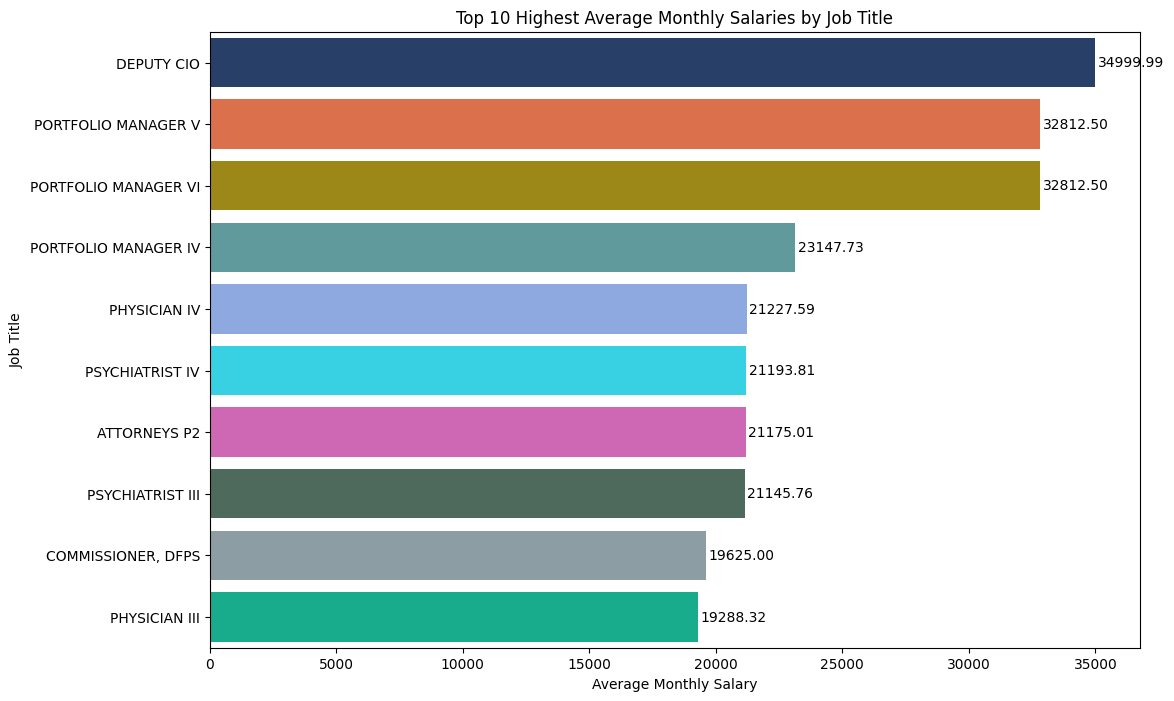

In [208]:
top10_salaries = df.groupby('job_title')['monthly_salary'].mean().sort_values(ascending=False).head(10)

top10_salaries = top10_salaries.reset_index()

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='monthly_salary', y='job_title', data=top10_salaries, palette=color_codes)

plt.title('Top 10 Highest Average Monthly Salaries by Job Title')
plt.xlabel('Average Monthly Salary')
plt.ylabel('Job Title')

for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(width + 100,  
             p.get_y() + p.get_height() / 2,  
             '{:1.2f}'.format(top10_salaries['monthly_salary'][i]),  
             va='center')  

plt.show()


Terlihat dari data CIO tertinggi.

### Golongan Pekerja dengan gaji tertinggi

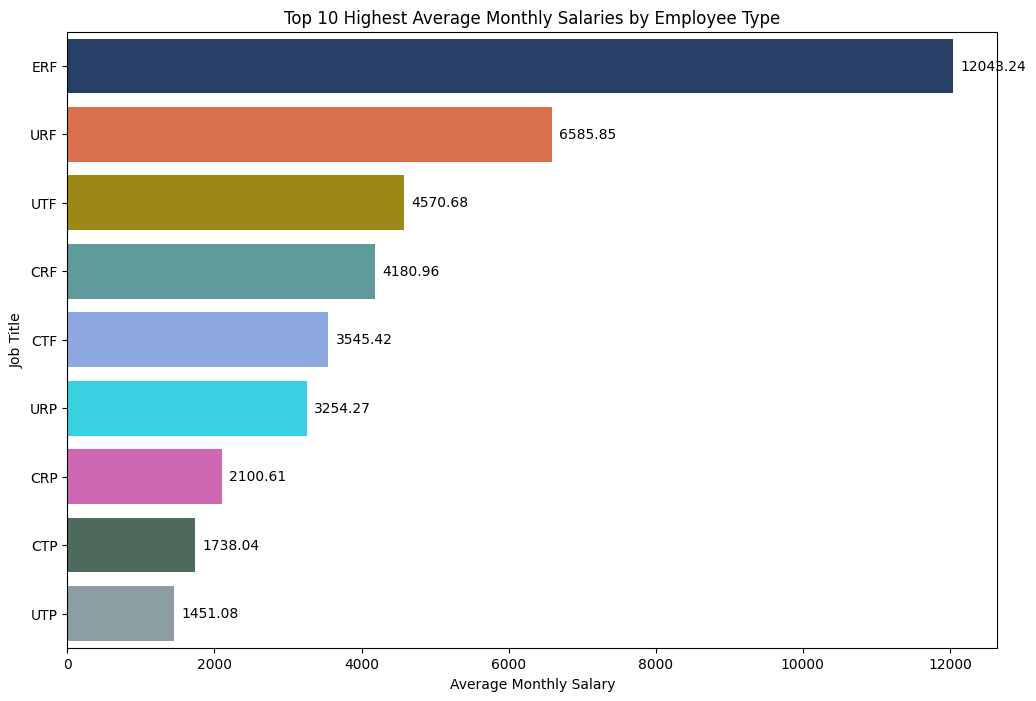

In [209]:
top10_salaries = df.groupby('employee_type')['monthly_salary'].mean().sort_values(ascending=False).head(10)

top10_salaries = top10_salaries.reset_index()

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='monthly_salary', y='employee_type', data=top10_salaries, palette=color_codes, ci=None)

plt.title('Top 10 Highest Average Monthly Salaries by Employee Type')
plt.xlabel('Average Monthly Salary')
plt.ylabel('Job Title')

for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(width + 100, 
             p.get_y() + p.get_height() / 2, 
             '{:1.2f}'.format(top10_salaries['monthly_salary'][i]), 
             va='center') 

plt.show()


### Komposisi Golongan ERF 

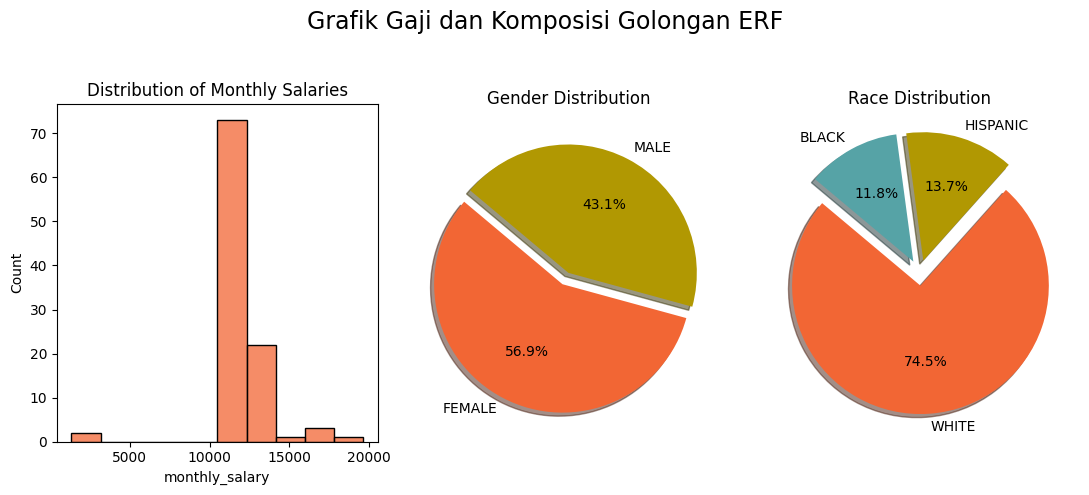

In [210]:
a= df[df['employee_type']== 'ERF']
a= a.drop(['hired_date',	'hired_month_year',	'agency_code', 'job_class', 'employee_type', 'classification',	'contract',	'status',	'hours_worked'	], axis=1)

fig = plt.figure(figsize=(11, 5))
fig.suptitle('Grafik Gaji dan Komposisi Golongan ERF\n', fontsize=17, ha='center')

plt.subplot(1, 3, 1)
sns.histplot(a['monthly_salary'], bins=10, kde=False, color= color_codes[1])
plt.title('Distribution of Monthly Salaries')

plt.subplot(1, 3, 2)
gender_counts = a['sex'].value_counts()
explode_gender = (0.1, 0) if len(gender_counts) == 2 else (0.1,) * len(gender_counts)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, explode=explode_gender, colors=color_codes[1:], shadow= True)
plt.title('Gender Distribution')

plt.subplot(1, 3, 3)
race_counts = a['race'].value_counts()
# Using a slight explode value for better visualization
explode_race = (0.1, 0) if len(race_counts) == 2 else (0.1,) * len(race_counts)
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140, explode=explode_race, colors=color_codes[1:], shadow= True)
plt.title('Race Distribution')

plt.tight_layout()

### 5 Pekerjaan terbanyak

In [211]:
a= df['job_title'].value_counts()
a.head(5)

job_title
CORREC OFFCR II                 2003
CORREC  OFFICER IV              1517
TEXAS WORKS ADVISOR I           1278
DIRECT SUPPORT PROF II          1204
CHILD PROTECTIVE SVCS SPEC I    1100
Name: count, dtype: int64

### Tren Perekrutan

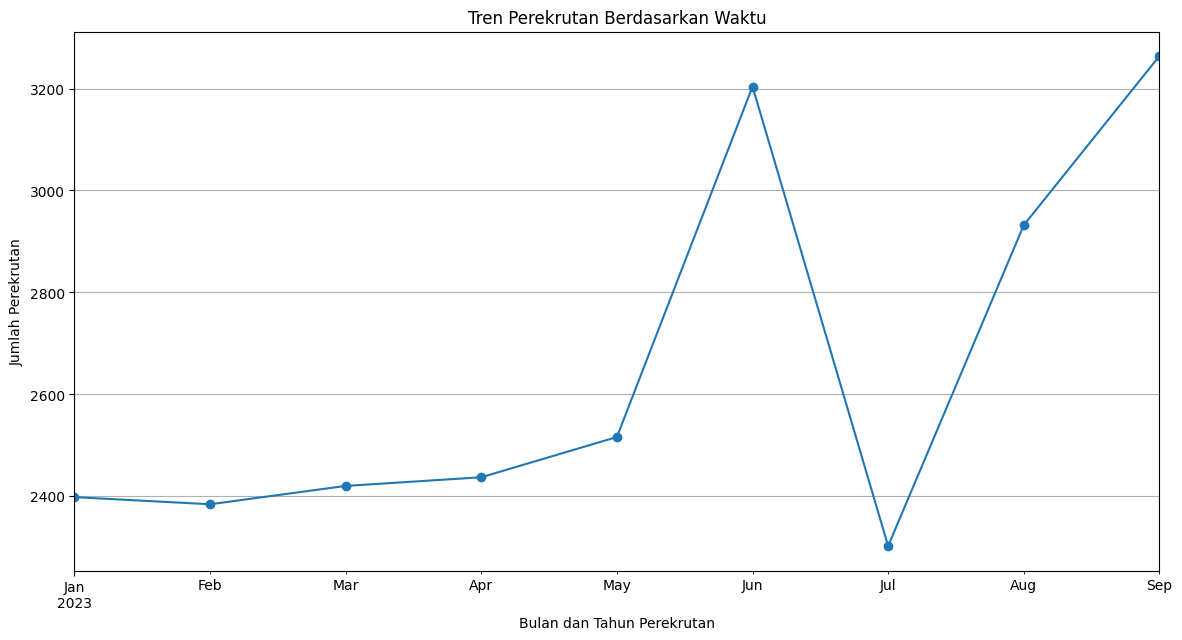

In [212]:
plt.figure(figsize=(14, 7))
df.groupby('hired_month_year').size().plot(kind='line', marker='o')
plt.title('Tren Perekrutan Berdasarkan Waktu')
plt.xlabel('Bulan dan Tahun Perekrutan')
plt.ylabel('Jumlah Perekrutan')
plt.grid(True)
plt.show()


# Feature Engineering

## Hapus Kolom (Tahap 1)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hired_date           23857 non-null  datetime64[ns]
 1   hired_month_year     23857 non-null  period[M]     
 2   agency_code          23857 non-null  int16         
 3   agency_name          23857 non-null  object        
 4   last_name            23857 non-null  object        
 5   first_name           23857 non-null  object        
 6   middle_name_initial  23857 non-null  object        
 7   sex                  23857 non-null  object        
 8   race                 23857 non-null  object        
 9   state_number         23857 non-null  int32         
 10  job_class            23857 non-null  object        
 11  job_title            23857 non-null  object        
 12  employee_type        23857 non-null  object        
 13  classification       23857 non-null

In [214]:
df.columns.to_list()

['hired_date',
 'hired_month_year',
 'agency_code',
 'agency_name',
 'last_name',
 'first_name',
 'middle_name_initial',
 'sex',
 'race',
 'state_number',
 'job_class',
 'job_title',
 'employee_type',
 'classification',
 'contract',
 'status',
 'hours_worked',
 'monthly_salary',
 'annual_salary']

In [215]:
df= df.drop([
    'hired_date',
    'hired_month_year',
    'agency_code',
    'last_name',
    'first_name',
    'job_title',
    'middle_name_initial',
    'state_number',
    'annual_salary',
    'employee_type'
], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   agency_name     23857 non-null  object 
 1   sex             23857 non-null  object 
 2   race            23857 non-null  object 
 3   job_class       23857 non-null  object 
 4   classification  23857 non-null  object 
 5   contract        23857 non-null  object 
 6   status          23857 non-null  object 
 7   hours_worked    23857 non-null  float32
 8   monthly_salary  23857 non-null  float64
dtypes: float32(1), float64(1), object(7)
memory usage: 1.7+ MB


## Correlation Check

### Encode Object Columns

In [216]:
enc = OrdinalEncoder()
df[["agency_name","sex", "race", "job_class", "classification", "contract", "status"]] = enc.fit_transform(df[["agency_name","sex", "race", "job_class", "classification", "contract", "status"]])
df.head()

,agency_name,sex,race,job_class,classification,contract,status,hours_worked,monthly_salary
6,44.0,0.0,3.0,685.0,2.0,0.0,1.0,20.0,2375.00
8,44.0,1.0,3.0,687.0,2.0,1.0,1.0,1.0,86.66
11,44.0,1.0,3.0,686.0,2.0,1.0,1.0,20.0,1213.33
12,26.0,1.0,3.0,694.0,2.0,0.0,1.0,20.0,500.00
14,27.0,0.0,5.0,882.0,2.0,0.0,1.0,30.0,3000.00


In [217]:
object_cols

,agency_name,last_name,first_name,middle_name_initial,sex,race,job_class,job_title,employee_type,classification,contract,status,annual_salary
6,SENATE,GONZALEZ,CYNTHIA,D,FEMALE,HISPANIC,7101,LEG. OFFICIAL/ADMINISTRATOR,URP,UNCLASSIFIED,REGULAR,PART-TIME,28500.0
8,SENATE,HERNANDEZ,JOHN,Z,MALE,HISPANIC,7103,LEG. SERVICE/MAINTENANCE,UTP,UNCLASSIFIED,TEMPORARY,PART-TIME,1039.92
11,SENATE,MALDANADO,ALEXANDER,P,MALE,HISPANIC,7102,LEGISLATIVE ADMIN. SUPPORT,UTP,UNCLASSIFIED,TEMPORARY,PART-TIME,14559.96
12,HOUSE OF REPRESENTATIVES,MALDANADO,ALEXANDER,P,MALE,HISPANIC,7110,ELECTED OFFICIALS STAFF,URP,UNCLASSIFIED,REGULAR,PART-TIME,6000.0
14,LEGISLATIVE BUDGET BOARD,MCGHEE,ANDREA,P,FEMALE,WHITE,P070,ANALYST,URP,UNCLASSIFIED,REGULAR,PART-TIME,36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146404,TREASURY SAFEKEEPING TRUST COMPANY,JENTSCH,KEVIN,F,MALE,WHITE,1022,ACCOUNTANT VI,URF,UNCLASSIFIED,REGULAR,FULL-TIME,90000.0
146410,TREASURY SAFEKEEPING TRUST COMPANY,LEE,HOI WAI,,MALE,ASIAN,0215,DATA ADMIN V,URF,UNCLASSIFIED,REGULAR,FULL-TIME,110004.0
146436,TREASURY SAFEKEEPING TRUST COMPANY,SURESH,SRI VAISHNAVI G,,FEMALE,ASIAN,0257,SYSTEM ANALYST VI,URF,UNCLASSIFIED,REGULAR,FULL-TIME,123265.8
146443,TREASURY SAFEKEEPING TRUST COMPANY,URBAN,DIANA,E,FEMALE,WHITE,1562,PROJECT MANAGER V,URF,UNCLASSIFIED,REGULAR,FULL-TIME,126000.0


In [218]:
low_object_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sex             23857 non-null  object
 1   race            23857 non-null  object
 2   employee_type   23857 non-null  object
 3   classification  23857 non-null  object
 4   contract        23857 non-null  object
 5   status          23857 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


In [219]:
hi_object_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 6 to 146444
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   agency_name          23857 non-null  object
 1   last_name            23857 non-null  object
 2   first_name           23857 non-null  object
 3   middle_name_initial  23857 non-null  object
 4   job_class            23857 non-null  object
 5   job_title            23857 non-null  object
 6   annual_salary        23857 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


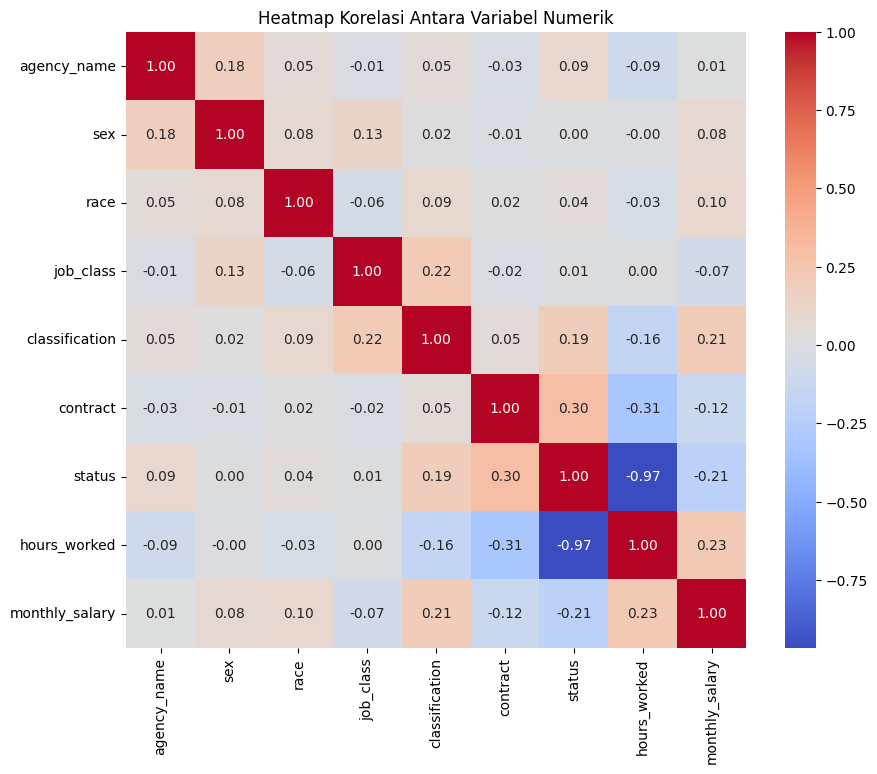

In [220]:
# Menghitung matriks korelasi
corr = df.corr()

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Heatmap Korelasi Antara Variabel Numerik')
plt.show()


In [221]:
corr[corr['monthly_salary'] > 0.01]['monthly_salary'].sort_values(ascending=False)

monthly_salary    1.000000
hours_worked      0.227962
classification    0.207840
race              0.099434
sex               0.083823
agency_name       0.013305
Name: monthly_salary, dtype: float64

## Outliers

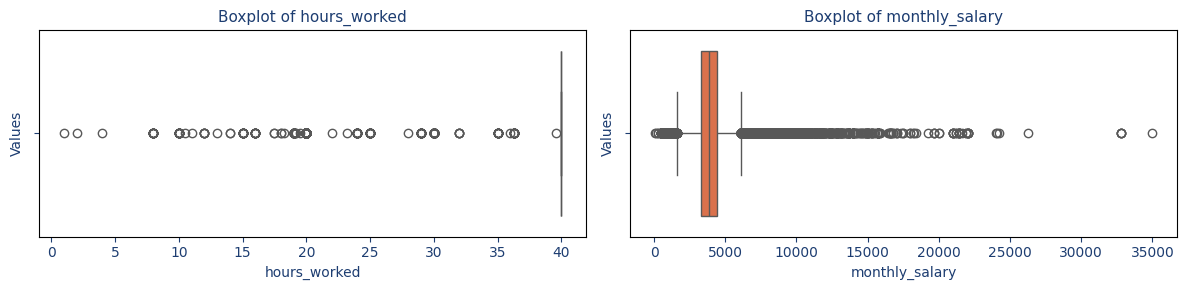

In [222]:
selected_columns= ['hours_worked', 'monthly_salary']
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

for j, kolom in enumerate(df[selected_columns]):
    sns.boxplot(x=df[kolom], ax=axs[j], color='#F26634')
    axs[j].set_facecolor('white')
    axs[j].set_title(f'Boxplot of {kolom}', color='#1D3D71', fontsize=11)
    axs[j].set_xlabel(kolom, color='#1D3D71')
    axs[j].set_ylabel('Values', color='#1D3D71')
    axs[j].tick_params(colors='#1D3D71')

plt.tight_layout()
plt.show()

In [223]:
Q1 = df["hours_worked"].quantile(0.25)
Q3 = df["hours_worked"].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outlier indices
outlier_indices = df[df["hours_worked"] > upper_bound].index
df = df.drop(outlier_indices)
df.shape

(23857, 9)

In [224]:
Q1 = df["monthly_salary"].quantile(0.25)
Q3 = df["monthly_salary"].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound, upper_bound)

# Identify the outlier indices
outlier_indices = df[df["monthly_salary"] > upper_bound].index
df = df.drop(outlier_indices)
df.shape

1618.9449999999997 6095.305


(21467, 9)

In [225]:
X = df.drop('monthly_salary', axis = 1)
y = df['monthly_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

print('Size Train Set :', X_train.shape)
print('Size Test Set :', X_test.shape)

Size Train Set : (15026, 8)
Size Test Set : (6441, 8)


## Pipeline 

Saya akan kembali bagi interger dan float

In [226]:
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['int64']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Nah pada tahp ini saya menggunakan piplines dengan membawa numeric transformer, categorical dan column transformer. Saya menggunakan StandardScaler, yang paling umum dan mudah digunakan untuk menyama ratakan skala dari fitur-fitur numerik.  Harapannya ini bisa memudahkan saya untuk mengoptimasinya.

# 6. Model Definition

Saya akan menggunakan berbagai jenis model regresi seperti Random Forest, K-Nearest Neighbors, Extra Trees, Gradient Boosting, dan Decision Tree.  

Menggunakan beberapa model sekaligus diharapkan dapat mendapatkan hasil terbaik karena pasti setiap dataset tidak bisa diberlakukan secara seragam model yang digunakan. Maka, ini adalah bagian dari experiment saya.  

In [227]:
# Define the models
models = {
    'rf' : Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestRegressor())]),
    'kn' : Pipeline(steps=[('preprocessor', preprocessor),('classifier', KNeighborsRegressor())]),
    'et' : Pipeline(steps=[('preprocessor', preprocessor),('classifier', ExtraTreesRegressor())]),
    'gb' : Pipeline(steps=[('preprocessor', preprocessor),('classifier', GradientBoostingRegressor())]),
    'dt' : Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeRegressor())]),
#     'kn' : KNeighborsRegressor(),
#     'et' : ExtraTreesRegressor(),
#     'gb' : GradientBoostingRegressor(),
#     'dt' : DecisionTreeRegressor(),
}

models_names = ['Random Forest', 'KNeighbors', 'ExtraTree', 'GradientBoosting','DecisionTree']

# 7. Model Training

Saya akan mulai melatih model

In [228]:
for name, model in models.items():
    model.fit(X_train, y_train)

model sudah dilatih. Selanjutnya saya akan melakukan prediksi.

# 8. Model Evaluation

## Predict Model 

In [229]:
r_score = []
mse = []
mae = []

result = pd.DataFrame(columns=['R_square', 'MSE', 'MAE'], index = models_names)

for name, model in models.items():
    pred = model.predict(X_test)
    r_score.append(r2_score(y_test, pred))
    mse.append(mean_squared_error(y_test, pred) ** .5)
    mae.append(mean_absolute_error(y_test, pred))

result.R_square = r_score
result.MSE = mse
result.MAE = mae

result.sort_values('R_square', ascending=False)

,R_square,MSE,MAE
Random Forest,0.866691,309.320746,153.103198
ExtraTree,0.840359,338.495026,167.426853
DecisionTree,0.819108,360.321455,161.614936
GradientBoosting,0.725686,443.714620,281.870271
KNeighbors,0.692308,469.935545,244.468145


NOTES M2:  
Tulis alasan2  
<!-- Pendahuluan jelaskan objektif -->
<!-- Hapus outliers   -->
Jangan lupa kesimpulan
Pkai hyp tuning  
pakai crooss val  


**Highlights**
1. Random Forest: tertinggi untuk R-square, tetapi terendah MSE dan MAE  
2. Gradient Boosting MAE tertinggi, MSE dan R_square not bad  
3. ExtraTree: R-square ke-2  
4. Decision Tree: Memiliki MSE dan MAE tertinggi.  

## Hyperparameter 

Di sini saya  melakukan Hyperparameter tuning untuk model pilihan saya yaitu Gradient Boosting. dengan parameter-parametr seperti di bawh ini. untuk memprediksi data test

In [230]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

gbm_model=GradientBoostingRegressor()
gbm_params = { 
    'n_estimators': [100, 500],
    'subsample': [1,0.5],
    'max_depth' : [3,8],
    "learning_rate": [0.01,0.1]
}

y = y.ravel()

In [231]:
gbm_best_grid = GridSearchCV(gbm_model,gbm_params, cv=5,n_jobs=-1, verbose=False).fit(X,y)

In [232]:
final=gbm_model.set_params(**gbm_best_grid.best_params_,random_state=17).fit(X,y)

In [233]:
final_test=final.predict(x_test)

In [234]:
print("R Square Score : ", r2_score(y_test,final_test))
print("MSE Score : ", mean_squared_error(y_test, final_test) ** .5)
print("MAE : ", mean_absolute_error(y_test, final_test))
print("Best Params : ", gbm_best_grid.best_params_)

R Square Score :  0.8740994302071141
MSE Score :  297.96308746168035
MAE :  176.77403685305993
Best Params :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1}


Saya akan membuat kesimpulan di akhir

# Model Saving

In [235]:
# Simpan model SVM ke dalam file
filename = 'model.pkl'

with open(filename, "wb") as f:
    pickle.dump(gbm_model, f)

print(f'Model Gradient Boosting saved as {filename}')

Model Gradient Boosting saved as model.pkl


# 10. Model Inference

In [236]:
X_test.iloc[:1]

,agency_name,sex,race,job_class,classification,contract,status,hours_worked
93519,75.0,0.0,5.0,756.0,0.0,0.0,0.0,40.0


In [237]:
# Load model SVM dari file
gbm_model = joblib.load('model.pkl')

# inference_data = {
#     'AGY': [101],
#     'NAME':["SENATE"],
#     'LASTNAME':["ALLENSWORTH"],
#     'FIRSTNAME':["ANNE"],
#     'MI':["R"],
#     'JOBCLASS':["7104"],
#     'JC TITLE':["LEGISLATIVE PROFESSIONAL"],
#     'RACE':["WHITE"],
#     'SEX':["FEMALE"],
#     'EMPTYPE':["URF - UNCLASSIFIED REGULAR FULL-TIME"],
#     'HIREDT':["11/16/22"],
#     'RATE':[0.0],
#     'HRSWKD':[40.0],
#     'MONTHLY':[4260.0],
#     'ANNUAL':[28500.0],
#     'STATENUM':["339273"], 
#     'duplicated':["TRUE"],
#     'multiple_full_time_jobs':["FALSE"],
#     'combined_multiple_jobs':["FALSE"],
#     'summed_annual_salary':[105000.0],
#     'hide_from_search':["TRUE"]
# }

# inference_df = pd.DataFrame(inference_data)

# inference_df

# sample_data = X_test.iloc[:100]
# predictions = gbm_model.predict(sample_data)

# # Analisis Hasil Inferensi
# predictions_df = pd.DataFrame(predictions, columns=['Predicted Month Salary'])

# # Menganalisis hasil prediksi
# print(predictions_df['Predicted Month Salary'])

In [238]:
# # define X and y
# X_inf = inference_df.drop(['AGY',
#     'LASTNAME',
#     'FIRSTNAME',
#     'MI',
#     'JC TITLE',
#     'STATENUM',
#     'duplicated',
#     'multiple_full_time_jobs',
#     'combined_multiple_jobs',
#     'summed_annual_salary',
#     'hide_from_search'],axis = 1)
# y_inf = inference_df['MONTHLY']
# X_inf

Tidak cukup waktu membuat np random

# Pengambilan Kesimpulan

- Secara umum, Gradient Boosting yang saya gunakan terbilang baik dengah hasil test R Square Score yang tinggi dan meningkat hasilnya dari data train.   
- MSE dan MAE cenderung overfitting. 
- Kekurangan Fitur: Seandainya terdapat informasi yang lebih baik seperti nama jabatan serta hirarkinya, pengalaman kerja, usia, dll mungkin hasil akan lebih bagus lagi.  
- Waktu persiapan data sangat panjang karena data masih sangat raw.  
- Keterbatasan waktu untuk experiment parameter-parameter yang ada.  
- Distribusi data banyak yang tidak balance.  
- Data ini mungkin akan lebih baik menggunakan Lienar Regression.  

Catatan:  
Best Params :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1}